GOAL : To predict the amount of electricity produced and consumed by Estonian energy customers who have installed solar panels. You'll have access to weather data, the relevant energy prices, and records of the installed photovoltaic capacity.

In [1]:
# General
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# others
import json
import geopandas as gpd
from shapely.geometry import Point

# Mappings

## County_id to name

In [2]:
with open('../data/county_id_to_name_map.json', 'r') as f:
    data = json.load(f)
print(data)


{'0': 'HARJUMAA', '1': 'HIIUMAA', '2': 'IDA-VIRUMAA', '3': 'JÄRVAMAA', '4': 'JÕGEVAMAA', '5': 'LÄÄNE-VIRUMAA', '6': 'LÄÄNEMAA', '7': 'PÄRNUMAA', '8': 'PÕLVAMAA', '9': 'RAPLAMAA', '10': 'SAAREMAA', '11': 'TARTUMAA', '12': 'UNKNOWN', '13': 'VALGAMAA', '14': 'VILJANDIMAA', '15': 'VÕRUMAA'}


## train.csv

In [3]:
df_train = pd.read_csv('../data/train.csv')

df_train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60


About the dataset :

<b>county</b> - An ID code for the county.<br>
<b>is_business</b> - Boolean for whether or not the prosumer is a business.<br>
<b>product_type</b> - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.<br>
<b>target</b> - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.<br>
<b>is_consumption</b> - Boolean for whether or not this row's target is consumption or production.<br>
<b>datetime</b> - The Estonian time in EET (UTC+2) / EEST (UTC+3). It describes the start of the 1-hour period on which target is given.<br>
<b>data_block_id</b> - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.<br>
<b>row_id</b> - A unique identifier for the row.<br>
<b>prediction_unit_id</b> - A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or disappear in the test set.<br>

In [4]:
# missing values
df_train.isnull().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

In [5]:
df_train = df_train.dropna(how='any')
df_train.shape

(2017824, 9)

## electricity_prices.csv

In [6]:
df_electricity = pd.read_csv('../data/electricity_prices.csv')
df_electricity

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1
...,...,...,...,...
15281,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637
15282,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637
15283,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637
15284,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00,637


## gas_prices.csv

In [7]:
df_gas = pd.read_csv('../data/gas_prices.csv')
df_gas

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5
...,...,...,...,...,...
632,2023-05-26,29.10,34.10,2023-05-25,633
633,2023-05-27,28.30,34.10,2023-05-26,634
634,2023-05-28,28.10,34.10,2023-05-27,635
635,2023-05-29,28.16,36.98,2023-05-28,636


## forecast_weather.csv

In [8]:
df_forecast_weather = pd.read_csv('../data/forecast_weather.csv')
df_forecast_weather

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,2023-05-30 02:00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
3424508,59.7,26.7,2023-05-30 02:00:00,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
3424509,59.7,27.2,2023-05-30 02:00:00,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
3424510,59.7,27.7,2023-05-30 02:00:00,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0


## historical_weather.csv

In [9]:
df_historical_weather = pd.read_csv('../data/historical_weather.csv')
df_historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710797,2023-05-30 10:00:00,11.7,4.6,0.0,0.0,1018.9,40,9,54,0,1.055556,253,567.0,392.0,175.0,59.7,26.2,637.0
1710798,2023-05-30 10:00:00,12.3,3.5,0.0,0.0,1019.0,46,4,70,0,0.805556,263,581.0,407.0,174.0,59.7,26.7,637.0
1710799,2023-05-30 10:00:00,9.8,3.0,0.0,0.0,1019.2,41,4,62,0,1.972222,285,609.0,432.0,177.0,59.7,27.2,637.0
1710800,2023-05-30 10:00:00,11.7,1.6,0.0,0.0,1019.0,44,0,73,0,3.500000,307,658.0,521.0,137.0,59.7,27.7,637.0


## client.csv

This file gives information about all the clients of the estonian energy who have installed solar panels.

In [10]:
df_client = pd.read_csv('../data/client.csv')
df_client

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2
...,...,...,...,...,...,...,...
41914,1,15,51,415.60,0,2023-05-29,637
41915,3,15,161,2035.75,0,2023-05-29,637
41916,0,15,15,620.00,1,2023-05-29,637
41917,1,15,20,624.50,1,2023-05-29,637


# EDA 

### Some conclusions assumptions made

## Visualizations

In [11]:
# df_gas['day_of_week'] = df_gas['forecast_date'].dt.day_name()
# df_gas

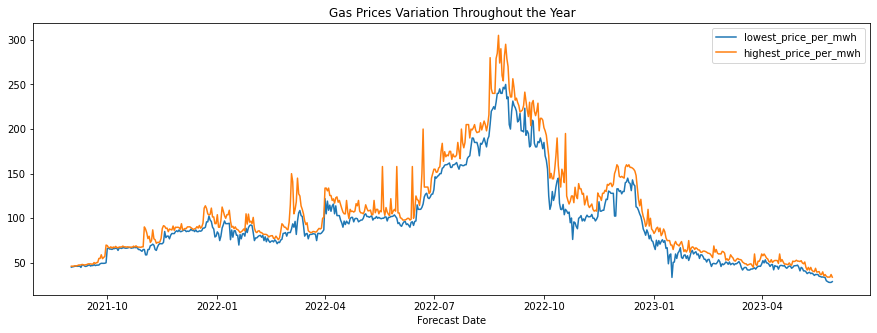

In [12]:
# Gas Prices :

# convert to datetime
df_gas['forecast_date'] = pd.to_datetime(df_gas['forecast_date'])
df_gas['origin_date'] = pd.to_datetime(df_gas['origin_date'])

df_gas['day_of_week'] = df_gas['forecast_date'].dt.day_name()

# Filter data for year 2022
df_gas_2022 = df_gas[df_gas['forecast_date'].dt.year == 2022]

# df_gas['forecast_date']
plt.figure(figsize=(15, 5))  # Adjust figure size as desired
plt.plot(df_gas['forecast_date'], df_gas['lowest_price_per_mwh'], label = 'lowest_price_per_mwh')
plt.plot(df_gas['forecast_date'], df_gas['highest_price_per_mwh'], label = 'highest_price_per_mwh')
plt.xlabel('Forecast Date')
plt.title('Gas Prices Variation Throughout the Year')
plt.legend()

plt.show()

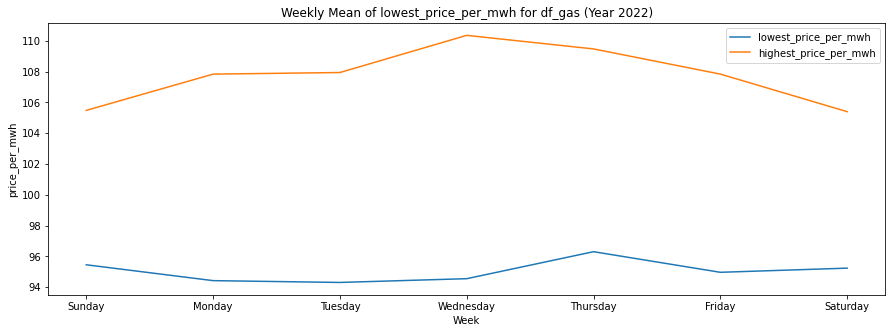

             lowest_price_per_mwh  highest_price_per_mwh  data_block_id
day_of_week                                                            
Sunday                  95.455495             105.477473          320.0
Monday                  94.426813             107.830549          321.0
Tuesday                 94.309560             107.934725          322.0
Wednesday               94.553846             110.347143          316.0
Thursday                96.305385             109.466484          317.0
Friday                  94.968242             107.831758          318.0
Saturday                95.237912             105.394286          319.0


In [13]:
# Resample by week and calculate mean (replace 'your_column_name' with the actual column)
weekly_mean = df_gas.groupby('day_of_week').mean()
# handling the days in rows from Monday to Sunday

weekly_mean = weekly_mean.reindex(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
# weekly_mean = df_gas.resample('W-SUN')['lowest_price_per_mwh'].mean()


# Plotting the weekly mean
plt.figure(figsize=(15, 5))  # Adjust figure size as desired
plt.plot(weekly_mean.index, weekly_mean['lowest_price_per_mwh'], label = 'lowest_price_per_mwh')
plt.plot(weekly_mean.index, weekly_mean['highest_price_per_mwh'], label = 'highest_price_per_mwh')

# Customize the plot for weeks (adjust labels accordingly)
plt.xlabel('Week')
plt.ylabel('price_per_mwh')
plt.title('Weekly Mean of lowest_price_per_mwh for df_gas (Year 2022)')  # Assuming data is for 2022
plt.legend()
plt.show()

print(weekly_mean)

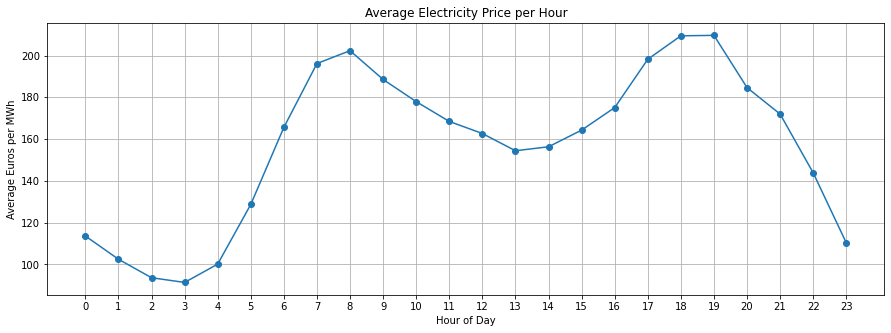

In [14]:
#Electrivity Prices

# Convert to datetime : 
df_electricity['forecast_date'] = pd.to_datetime(df_electricity['forecast_date'])
df_electricity['origin_date'] = pd.to_datetime(df_electricity['origin_date'])

# Extract the hour from the 'forecast_date' column
df_electricity['hour'] = df_electricity['forecast_date'].dt.hour

# Calculate average electricity price per hour
avg_price_per_hour = df_electricity.groupby('hour')['euros_per_mwh'].mean()
hours = avg_price_per_hour.index.to_numpy()  # Extract hours for the plot

# Create the plot
plt.figure(figsize=(15, 5))
plt.plot(hours, avg_price_per_hour.values, marker='o', linestyle='-')

# Customize the plot
plt.xlabel('Hour of Day')
plt.ylabel('Average Euros per MWh')
plt.title('Average Electricity Price per Hour')
plt.grid(True)
plt.xticks(range(24))  # Set x-axis ticks for all hours (0-23)

# Show the plot
plt.show()

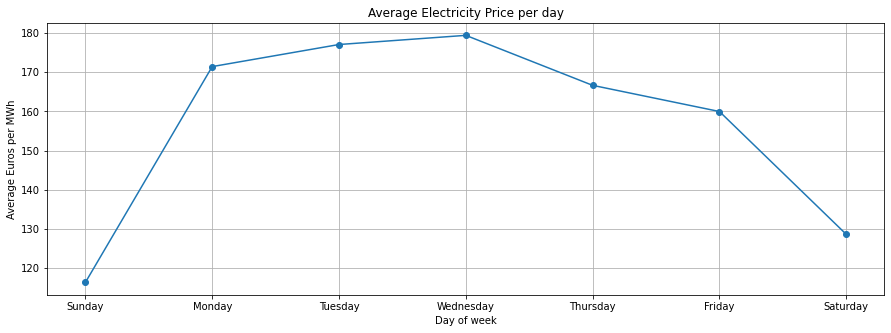

In [15]:
# Extract the hour from the 'forecast_date' column
df_electricity['day_of_week'] = df_electricity['forecast_date'].dt.day_name()
# df_electricity

# Calculate average electricity price per hour
avg_price_per_day = df_electricity.groupby('day_of_week')['euros_per_mwh'].mean()
avg_price_per_day = avg_price_per_day.reindex(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])

days_of_week = avg_price_per_day.index.to_numpy()  # Extract days for the plot

# avg_price_per_day
# Create the plot
plt.figure(figsize=(15, 5))
plt.plot(days_of_week, avg_price_per_day.values, marker='o', linestyle='-')

# # Customize the plot
plt.xlabel('Day of week')
plt.ylabel('Average Euros per MWh')
plt.title('Average Electricity Price per day')
plt.grid(True)
# plt.xticks(range(7))  # Set x-axis ticks for all hours (0-23)

# Show the plot
plt.show()

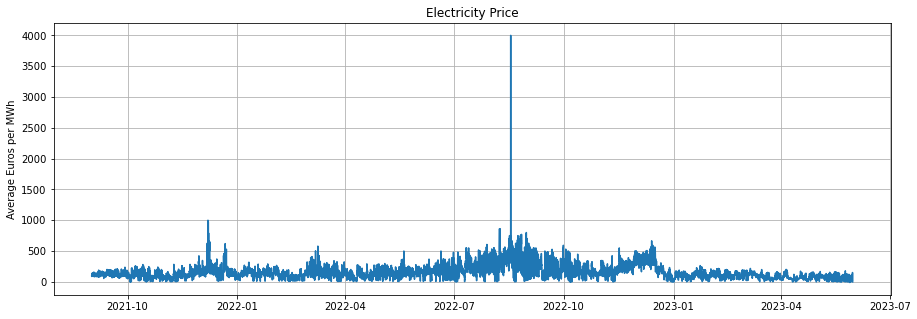

In [16]:
# electricity prices

# Create the plot
plt.figure(figsize=(15, 5))
plt.plot(df_electricity['forecast_date'], df_electricity['euros_per_mwh'])

# # Customize the plot
plt.ylabel('Average Euros per MWh')
plt.title('Electricity Price')
plt.grid(True)
# plt.xticks(range(7))  # Set x-axis ticks for all hours (0-23)

# Show the plot
plt.show()

It contains an outlier. Here is the boxplot for that outlier

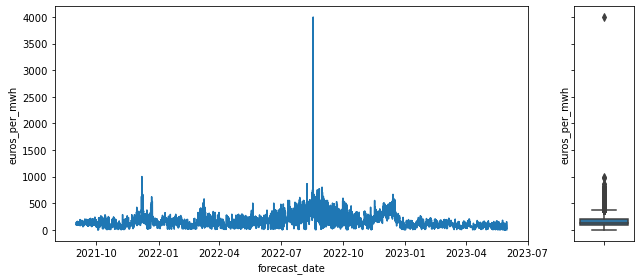

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)
_ = sns.lineplot(x = df_electricity['forecast_date'], y = df_electricity['euros_per_mwh'], ax=axs[0])
_ = sns.boxplot(data = df_electricity, y = df_electricity['euros_per_mwh'], ax=axs[1])
fig.tight_layout()

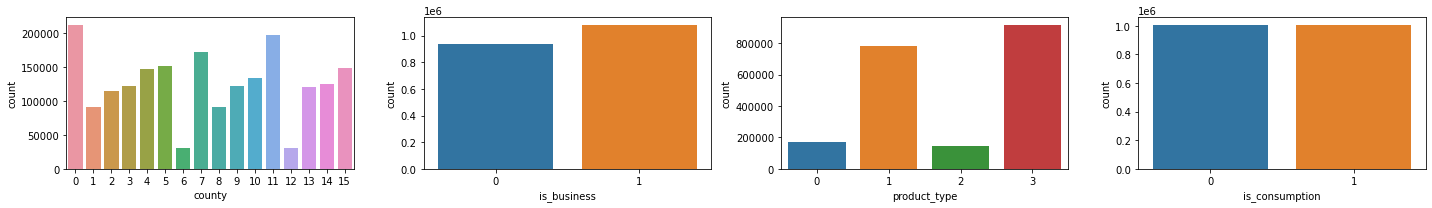

In [18]:
# counts for the county, business and product
columns = ['county','is_business','product_type','is_consumption']

fig, axs = plt.subplots(1, len(columns), figsize=(5*len(columns), 3))

for i, column in enumerate(columns):
    _ = sns.countplot(data = df_train, x=df_train[column], ax=axs[i])

_ = fig.tight_layout()

# Feature Engineering

## 1. Merging the weather data with the training data

In [19]:
# removing the unnecessary columns from both forecast weather and historical weather

# forecast_weather.csv
df_forecast_weather = df_forecast_weather[['latitude', 'longitude', 'origin_datetime', 'hours_ahead',
       'temperature', 'cloudcover_total', 'data_block_id', 'forecast_datetime', 'direct_solar_radiation',
       'snowfall', 'total_precipitation']]

# historical_weather.csv
df_historical_weather = df_historical_weather[['datetime', 'temperature', 'rain', 'snowfall',
       'cloudcover_total', 'direct_solar_radiation',
       'latitude', 'longitude', 'data_block_id']]

(df_forecast_weather)

,latitude,longitude,origin_datetime,hours_ahead,temperature,cloudcover_total,data_block_id,forecast_datetime,direct_solar_radiation,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,0.905899,1,2021-09-01 03:00:00,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,0.886658,1,2021-09-01 03:00:00,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,0.730499,1,2021-09-01 03:00:00,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,0.385468,1,2021-09-01 03:00:00,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,0.176590,1,2021-09-01 03:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,2023-05-30 02:00:00,48,10.150049,0.308594,637,2023-06-01 02:00:00,0.0,0.0,0.0
3424508,59.7,26.7,2023-05-30 02:00:00,48,10.259790,0.906036,637,2023-06-01 02:00:00,0.0,0.0,0.0
3424509,59.7,27.2,2023-05-30 02:00:00,48,10.467798,0.530518,637,2023-06-01 02:00:00,0.0,0.0,0.0
3424510,59.7,27.7,2023-05-30 02:00:00,48,10.694116,0.997498,637,2023-06-01 02:00:00,0.0,0.0,0.0


In [20]:
df_historical_weather

,datetime,temperature,rain,snowfall,cloudcover_total,direct_solar_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,0.0,0.0,31,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,0.0,0.0,33,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,0.0,0.0,31,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,0.0,0.0,0,277.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,0.0,0.0,22,0.0,57.6,23.7,1.0
...,...,...,...,...,...,...,...,...,...
1710797,2023-05-30 10:00:00,11.7,0.0,0.0,40,392.0,59.7,26.2,637.0
1710798,2023-05-30 10:00:00,12.3,0.0,0.0,46,407.0,59.7,26.7,637.0
1710799,2023-05-30 10:00:00,9.8,0.0,0.0,41,432.0,59.7,27.2,637.0
1710800,2023-05-30 10:00:00,11.7,0.0,0.0,44,521.0,59.7,27.7,637.0


In [21]:
# renaming the columns
df_forecast_weather.rename(columns = {
    'temperature' : 'forecast_temp',
    'cloudcover_total' : 'forecast_cloudcover',
    'direct_solar_radiation' : 'forecast_solar_radiation',
    'snowfall' : 'forecast_snowfall',
    'total_precipitation' : 'forecast_rain'
}, inplace = True)

df_forecast_weather

C:\Users\hbalu\AppData\Local\Temp\ipykernel_1748\3963912667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecast_weather.rename(columns = {


,latitude,longitude,origin_datetime,hours_ahead,forecast_temp,forecast_cloudcover,data_block_id,forecast_datetime,forecast_solar_radiation,forecast_snowfall,forecast_rain
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,0.905899,1,2021-09-01 03:00:00,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,0.886658,1,2021-09-01 03:00:00,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,0.730499,1,2021-09-01 03:00:00,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,0.385468,1,2021-09-01 03:00:00,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,0.176590,1,2021-09-01 03:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,2023-05-30 02:00:00,48,10.150049,0.308594,637,2023-06-01 02:00:00,0.0,0.0,0.0
3424508,59.7,26.7,2023-05-30 02:00:00,48,10.259790,0.906036,637,2023-06-01 02:00:00,0.0,0.0,0.0
3424509,59.7,27.2,2023-05-30 02:00:00,48,10.467798,0.530518,637,2023-06-01 02:00:00,0.0,0.0,0.0
3424510,59.7,27.7,2023-05-30 02:00:00,48,10.694116,0.997498,637,2023-06-01 02:00:00,0.0,0.0,0.0


In [22]:
df_historical_weather.rename(columns = {
    'cloudcover_total' : 'cloudcover',
}, inplace = True)

df_historical_weather

C:\Users\hbalu\AppData\Local\Temp\ipykernel_1748\105257739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_historical_weather.rename(columns = {


,datetime,temperature,rain,snowfall,cloudcover,direct_solar_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,0.0,0.0,31,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,0.0,0.0,33,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,0.0,0.0,31,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,0.0,0.0,0,277.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,0.0,0.0,22,0.0,57.6,23.7,1.0
...,...,...,...,...,...,...,...,...,...
1710797,2023-05-30 10:00:00,11.7,0.0,0.0,40,392.0,59.7,26.2,637.0
1710798,2023-05-30 10:00:00,12.3,0.0,0.0,46,407.0,59.7,26.7,637.0
1710799,2023-05-30 10:00:00,9.8,0.0,0.0,41,432.0,59.7,27.2,637.0
1710800,2023-05-30 10:00:00,11.7,0.0,0.0,44,521.0,59.7,27.7,637.0


In [23]:
# subsetting the forecast_weather based on hours_ahead only.

df_forecast_weather = df_forecast_weather.loc[(df_forecast_weather['hours_ahead'] <= 24)]
df_forecast_weather = df_forecast_weather.drop(['hours_ahead'], axis = 1)
df_forecast_weather

,latitude,longitude,origin_datetime,forecast_temp,forecast_cloudcover,data_block_id,forecast_datetime,forecast_solar_radiation,forecast_snowfall,forecast_rain
0,57.6,21.7,2021-09-01 02:00:00,15.655786,0.905899,1,2021-09-01 03:00:00,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,13.003931,0.886658,1,2021-09-01 03:00:00,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,14.206567,0.730499,1,2021-09-01 03:00:00,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,14.844507,0.385468,1,2021-09-01 03:00:00,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,15.293848,0.176590,1,2021-09-01 03:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3421819,59.7,26.2,2023-05-30 02:00:00,10.051660,0.153320,637,2023-05-31 02:00:00,0.0,0.0,0.0
3421820,59.7,26.7,2023-05-30 02:00:00,10.394189,0.135986,637,2023-05-31 02:00:00,0.0,0.0,0.0
3421821,59.7,27.2,2023-05-30 02:00:00,10.448145,0.181671,637,2023-05-31 02:00:00,0.0,0.0,0.0
3421822,59.7,27.7,2023-05-30 02:00:00,10.054834,0.014954,637,2023-05-31 02:00:00,0.0,0.0,0.0


In [24]:
# merge

weather = pd.merge(df_historical_weather, df_forecast_weather, how = 'inner',
                   left_on = ['datetime', 'latitude', 'longitude'],
                   right_on = ['forecast_datetime', 'latitude', 'longitude'])
weather

,datetime,temperature,rain,snowfall,cloudcover,direct_solar_radiation,latitude,longitude,data_block_id_x,origin_datetime,forecast_temp,forecast_cloudcover,data_block_id_y,forecast_datetime,forecast_solar_radiation,forecast_snowfall,forecast_rain
0,2021-09-01 03:00:00,14.3,0.0,0.0,34,0.0,57.6,21.7,1.0,2021-09-01 02:00:00,15.655786,0.905899,1,2021-09-01 03:00:00,0.000000,0.0,0.000000
1,2021-09-01 03:00:00,13.7,0.0,0.0,26,0.0,57.6,22.2,1.0,2021-09-01 02:00:00,13.003931,0.886658,1,2021-09-01 03:00:00,0.000000,0.0,0.000000
2,2021-09-01 03:00:00,13.8,0.0,0.0,39,0.0,57.6,22.7,1.0,2021-09-01 02:00:00,14.206567,0.730499,1,2021-09-01 03:00:00,0.000000,0.0,0.000000
3,2021-09-01 03:00:00,14.1,0.0,0.0,0,7.0,57.6,23.2,1.0,2021-09-01 02:00:00,14.844507,0.385468,1,2021-09-01 03:00:00,0.000000,0.0,0.000000
4,2021-09-01 03:00:00,15.6,0.0,0.0,76,0.0,57.6,23.7,1.0,2021-09-01 02:00:00,15.293848,0.176590,1,2021-09-01 03:00:00,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710461,2023-05-30 10:00:00,11.7,0.0,0.0,40,392.0,59.7,26.2,637.0,2023-05-30 02:00:00,9.646875,0.040192,637,2023-05-30 10:00:00,616.044831,0.0,0.000008
1710462,2023-05-30 10:00:00,12.3,0.0,0.0,46,407.0,59.7,26.7,637.0,2023-05-30 02:00:00,8.517480,0.112030,637,2023-05-30 10:00:00,754.427053,0.0,0.000000
1710463,2023-05-30 10:00:00,9.8,0.0,0.0,41,432.0,59.7,27.2,637.0,2023-05-30 02:00:00,9.211084,0.243225,637,2023-05-30 10:00:00,811.529275,0.0,0.000000
1710464,2023-05-30 10:00:00,11.7,0.0,0.0,44,521.0,59.7,27.7,637.0,2023-05-30 02:00:00,9.280176,0.259827,637,2023-05-30 10:00:00,826.249275,0.0,0.000000


In [25]:
weather.isna().sum()

datetime                    0
temperature                 0
rain                        0
snowfall                    0
cloudcover                  0
direct_solar_radiation      0
latitude                    0
longitude                   0
data_block_id_x             0
origin_datetime             0
forecast_temp               0
forecast_cloudcover         0
data_block_id_y             0
forecast_datetime           0
forecast_solar_radiation    0
forecast_snowfall           0
forecast_rain               0
dtype: int64

In [26]:
# remove the unnecesary columns
weather = weather[['datetime', 'temperature', 'rain', 'snowfall', 'cloudcover',
        'direct_solar_radiation', 'latitude', 'longitude', 'data_block_id_x',
        'forecast_temp', 'forecast_cloudcover', 'data_block_id_y', 
        'forecast_solar_radiation', 'forecast_snowfall',
        'forecast_rain']]
weather

,datetime,temperature,rain,snowfall,cloudcover,direct_solar_radiation,latitude,longitude,data_block_id_x,forecast_temp,forecast_cloudcover,data_block_id_y,forecast_solar_radiation,forecast_snowfall,forecast_rain
0,2021-09-01 03:00:00,14.3,0.0,0.0,34,0.0,57.6,21.7,1.0,15.655786,0.905899,1,0.000000,0.0,0.000000
1,2021-09-01 03:00:00,13.7,0.0,0.0,26,0.0,57.6,22.2,1.0,13.003931,0.886658,1,0.000000,0.0,0.000000
2,2021-09-01 03:00:00,13.8,0.0,0.0,39,0.0,57.6,22.7,1.0,14.206567,0.730499,1,0.000000,0.0,0.000000
3,2021-09-01 03:00:00,14.1,0.0,0.0,0,7.0,57.6,23.2,1.0,14.844507,0.385468,1,0.000000,0.0,0.000000
4,2021-09-01 03:00:00,15.6,0.0,0.0,76,0.0,57.6,23.7,1.0,15.293848,0.176590,1,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710461,2023-05-30 10:00:00,11.7,0.0,0.0,40,392.0,59.7,26.2,637.0,9.646875,0.040192,637,616.044831,0.0,0.000008
1710462,2023-05-30 10:00:00,12.3,0.0,0.0,46,407.0,59.7,26.7,637.0,8.517480,0.112030,637,754.427053,0.0,0.000000
1710463,2023-05-30 10:00:00,9.8,0.0,0.0,41,432.0,59.7,27.2,637.0,9.211084,0.243225,637,811.529275,0.0,0.000000
1710464,2023-05-30 10:00:00,11.7,0.0,0.0,44,521.0,59.7,27.7,637.0,9.280176,0.259827,637,826.249275,0.0,0.000000


In [27]:
# reorder the columns
weather = weather.loc[:, ['datetime', 'latitude', 'longitude', 'data_block_id_x', 'data_block_id_y',
                          'temperature', 'forecast_temp',
                          'rain', 'forecast_rain',
                          'snowfall', 'forecast_snowfall',
                          'cloudcover', 'forecast_cloudcover',
                          'direct_solar_radiation','forecast_solar_radiation'
                         ]]
weather

,datetime,latitude,longitude,data_block_id_x,data_block_id_y,temperature,forecast_temp,rain,forecast_rain,snowfall,forecast_snowfall,cloudcover,forecast_cloudcover,direct_solar_radiation,forecast_solar_radiation
0,2021-09-01 03:00:00,57.6,21.7,1.0,1,14.3,15.655786,0.0,0.000000,0.0,0.0,34,0.905899,0.0,0.000000
1,2021-09-01 03:00:00,57.6,22.2,1.0,1,13.7,13.003931,0.0,0.000000,0.0,0.0,26,0.886658,0.0,0.000000
2,2021-09-01 03:00:00,57.6,22.7,1.0,1,13.8,14.206567,0.0,0.000000,0.0,0.0,39,0.730499,0.0,0.000000
3,2021-09-01 03:00:00,57.6,23.2,1.0,1,14.1,14.844507,0.0,0.000000,0.0,0.0,0,0.385468,7.0,0.000000
4,2021-09-01 03:00:00,57.6,23.7,1.0,1,15.6,15.293848,0.0,0.000000,0.0,0.0,76,0.176590,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710461,2023-05-30 10:00:00,59.7,26.2,637.0,637,11.7,9.646875,0.0,0.000008,0.0,0.0,40,0.040192,392.0,616.044831
1710462,2023-05-30 10:00:00,59.7,26.7,637.0,637,12.3,8.517480,0.0,0.000000,0.0,0.0,46,0.112030,407.0,754.427053
1710463,2023-05-30 10:00:00,59.7,27.2,637.0,637,9.8,9.211084,0.0,0.000000,0.0,0.0,41,0.243225,432.0,811.529275
1710464,2023-05-30 10:00:00,59.7,27.7,637.0,637,11.7,9.280176,0.0,0.000000,0.0,0.0,44,0.259827,521.0,826.249275


In [28]:
def weather_plots(df, x, y):
    fig, axs = plt.subplots(1, 1, figsize=(15, 5))
    
    _ = sns.lineplot(data = df[['datetime', x, y]])

    _ = fig.tight_layout()

KeyboardInterrupt: 

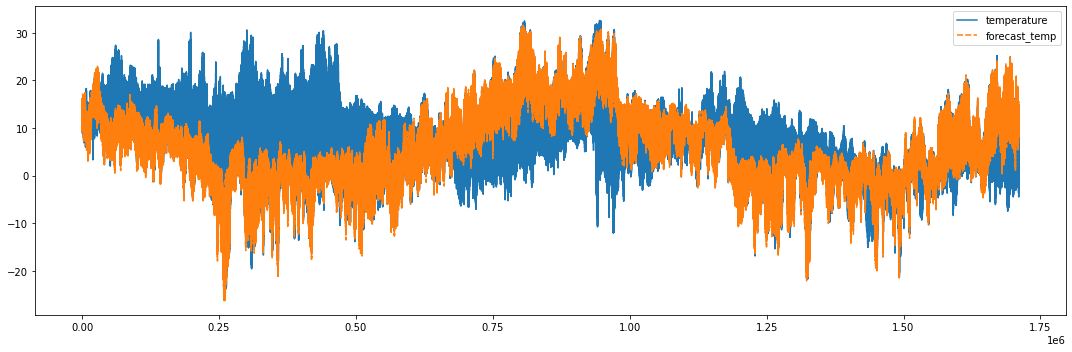

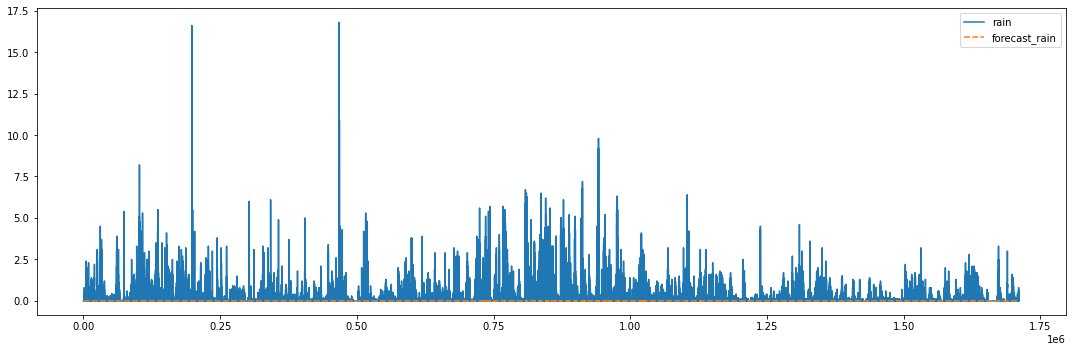

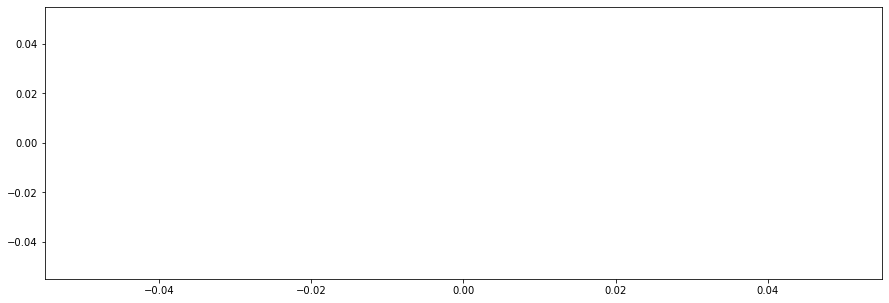

In [29]:
# !!!! SEEMS TO BE A PROBLEM WITH THIS SPECIFIC CELL AND HENCE CANNOT VISUALIZE !!!!
# MAYBE THIS IS DUE TO VERY LARGE SIZE OF THE DATA



# # forecast weather and actual weather plots
# c1 = ['temperature','rain','snowfall','cloudcover', 'direct_solar_radiation']
# c2 = ['forecast_temp','forecast_rain','forecast_snowfall','forecast_cloudcover', 'forecast_solar_radiation']  

# # fig, axs = plt.subplots(1, 1, figsize=(15, 5))

# # _ = sns.lineplot(data = weather[['datetime', c1[0], c2[0]]])

# # _ = fig.tight_layout()

# for i in range(0, 4):
#     weather_plots(weather, c1[i], c2[i])

Temperature and forecasted temperature seems to be important. Nothing else can be concluded on the other attributes.

In [30]:
weather.nunique()

datetime                     15270
latitude                         8
longitude                       14
data_block_id_x                637
data_block_id_y                637
temperature                    558
forecast_temp               322668
rain                            80
forecast_rain               270648
snowfall                        35
forecast_snowfall           133873
cloudcover                     101
forecast_cloudcover         382726
direct_solar_radiation         745
forecast_solar_radiation    640838
dtype: int64

So, apparently, the provided dataset has some fault. forecast_rain, forecast_snowfall and forcast_solar_radiation seems to have only 1 value. So, it makes sense to remove those forecasted values because they will have 0 significance whent the XGBoost model is trained. Will keep the respective related historical values as it is, because they might make some sense.

In [31]:
# removing the columns
weather = weather[['datetime', 'latitude', 'longitude', 'data_block_id_x',
       'data_block_id_y', 'temperature', 'forecast_temp', 'rain',
       'snowfall', 'cloudcover', 'forecast_cloudcover', 'direct_solar_radiation']]

weather

,datetime,latitude,longitude,data_block_id_x,data_block_id_y,temperature,forecast_temp,rain,snowfall,cloudcover,forecast_cloudcover,direct_solar_radiation
0,2021-09-01 03:00:00,57.6,21.7,1.0,1,14.3,15.655786,0.0,0.0,34,0.905899,0.0
1,2021-09-01 03:00:00,57.6,22.2,1.0,1,13.7,13.003931,0.0,0.0,26,0.886658,0.0
2,2021-09-01 03:00:00,57.6,22.7,1.0,1,13.8,14.206567,0.0,0.0,39,0.730499,0.0
3,2021-09-01 03:00:00,57.6,23.2,1.0,1,14.1,14.844507,0.0,0.0,0,0.385468,7.0
4,2021-09-01 03:00:00,57.6,23.7,1.0,1,15.6,15.293848,0.0,0.0,76,0.176590,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1710461,2023-05-30 10:00:00,59.7,26.2,637.0,637,11.7,9.646875,0.0,0.0,40,0.040192,392.0
1710462,2023-05-30 10:00:00,59.7,26.7,637.0,637,12.3,8.517480,0.0,0.0,46,0.112030,407.0
1710463,2023-05-30 10:00:00,59.7,27.2,637.0,637,9.8,9.211084,0.0,0.0,41,0.243225,432.0
1710464,2023-05-30 10:00:00,59.7,27.7,637.0,637,11.7,9.280176,0.0,0.0,44,0.259827,521.0


In [32]:
# just checking if really there are no county matching for countyID 1.
# longitude = 22.7
# latitude = 58.8
weather.loc[(weather['longitude'] == 22.7) & (weather['latitude'] == 58.8)]

,datetime,latitude,longitude,data_block_id_x,data_block_id_y,temperature,forecast_temp,rain,snowfall,cloudcover,forecast_cloudcover,direct_solar_radiation
58,2021-09-01 03:00:00,58.8,22.7,1.0,1,14.1,12.907617,0.0,0.0,11,0.283341,0.0
170,2021-09-01 04:00:00,58.8,22.7,1.0,1,14.2,13.201318,0.0,0.0,5,0.642609,0.0
282,2021-09-01 05:00:00,58.8,22.7,1.0,1,14.1,13.435938,0.0,0.0,11,0.467896,0.0
394,2021-09-01 06:00:00,58.8,22.7,1.0,1,14.0,13.359399,0.0,0.0,24,0.756470,1.0
506,2021-09-01 07:00:00,58.8,22.7,1.0,1,14.0,13.636499,0.0,0.0,35,0.687607,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1709964,2023-05-30 06:00:00,58.8,22.7,637.0,637,11.0,11.200586,0.0,0.0,11,0.159637,11.0
1710076,2023-05-30 07:00:00,58.8,22.7,637.0,637,11.2,12.092310,0.0,0.0,20,0.219086,84.0
1710188,2023-05-30 08:00:00,58.8,22.7,637.0,637,11.5,12.962915,0.0,0.0,16,0.692444,273.0
1710300,2023-05-30 09:00:00,58.8,22.7,637.0,637,12.3,12.484399,0.1,0.0,19,0.513062,348.0


The above rows did not match. WTF \n
PS : THEY DID

The resulting df will tell what the forecast was and what was the actual weather at that time and location.

## 2. Geographical coordinates and county merging

In [33]:
mapping = pd.read_csv('../data/weather_station_to_county_mapping.csv')
mapping

,county_name,longitude,latitude,county
0,Saaremaa,22.2,58.2,10
1,Saaremaa,22.2,58.5,10
2,Saaremaa,22.7,58.5,10
3,Hiiumaa,22.7,58.8,1
4,Saaremaa,23.2,58.5,10
5,Pärnumaa,23.7,58.5,7
6,Läänemaa,23.7,58.8,6
7,Läänemaa,23.7,59.1,6
8,Pärnumaa,24.2,58.5,7
9,Raplamaa,24.2,58.8,9


In [34]:
# merging weather and county maps-weather station data to introduce the county Id in the weather dataset.

# Merge the datasets based on latitude and longitude
weather = pd.merge(weather, mapping, on=['latitude', 'longitude'], how='left')

weather

,datetime,latitude,longitude,data_block_id_x,data_block_id_y,temperature,forecast_temp,rain,snowfall,cloudcover,forecast_cloudcover,direct_solar_radiation,county_name,county
0,2021-09-01 03:00:00,57.6,21.7,1.0,1,14.3,15.655786,0.0,0.0,34,0.905899,0.0,NaN,NaN
1,2021-09-01 03:00:00,57.6,22.2,1.0,1,13.7,13.003931,0.0,0.0,26,0.886658,0.0,NaN,NaN
2,2021-09-01 03:00:00,57.6,22.7,1.0,1,13.8,14.206567,0.0,0.0,39,0.730499,0.0,NaN,NaN
3,2021-09-01 03:00:00,57.6,23.2,1.0,1,14.1,14.844507,0.0,0.0,0,0.385468,7.0,NaN,NaN
4,2021-09-01 03:00:00,57.6,23.7,1.0,1,15.6,15.293848,0.0,0.0,76,0.176590,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710461,2023-05-30 10:00:00,59.7,26.2,637.0,637,11.7,9.646875,0.0,0.0,40,0.040192,392.0,NaN,NaN
1710462,2023-05-30 10:00:00,59.7,26.7,637.0,637,12.3,8.517480,0.0,0.0,46,0.112030,407.0,NaN,NaN
1710463,2023-05-30 10:00:00,59.7,27.2,637.0,637,9.8,9.211084,0.0,0.0,41,0.243225,432.0,NaN,NaN
1710464,2023-05-30 10:00:00,59.7,27.7,637.0,637,11.7,9.280176,0.0,0.0,44,0.259827,521.0,NaN,NaN


In [35]:
# check for missing values
weather.isna().sum()

datetime                       0
latitude                       0
longitude                      0
data_block_id_x                0
data_block_id_y                0
temperature                    0
forecast_temp                  0
rain                           0
snowfall                       0
cloudcover                     0
forecast_cloudcover            0
direct_solar_radiation         0
county_name               962138
county                    962138
dtype: int64

In [36]:
weather.nunique()

datetime                   15270
latitude                       8
longitude                     14
data_block_id_x              637
data_block_id_y              637
temperature                  558
forecast_temp             322668
rain                          80
snowfall                      35
cloudcover                   101
forecast_cloudcover       382726
direct_solar_radiation       745
county_name                   15
county                        15
dtype: int64

In [37]:
# dropping all the missing values
weather = weather.dropna()

# renaming county to countyID
weather.rename(columns = {'county' : 'countyID'}, inplace = True)
weather

C:\Users\hbalu\AppData\Local\Temp\ipykernel_1748\2952798544.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather.rename(columns = {'county' : 'countyID'}, inplace = True)


,datetime,latitude,longitude,data_block_id_x,data_block_id_y,temperature,forecast_temp,rain,snowfall,cloudcover,forecast_cloudcover,direct_solar_radiation,county_name,countyID
10,2021-09-01 03:00:00,57.6,26.7,1.0,1,11.6,9.876489,0.0,0.0,61,0.026001,0.0,Võrumaa,15.0
11,2021-09-01 03:00:00,57.6,27.2,1.0,1,11.9,10.815576,0.0,0.0,98,0.761780,0.0,Võrumaa,15.0
23,2021-09-01 03:00:00,57.9,26.2,1.0,1,11.6,10.058984,0.0,0.0,68,0.332809,0.0,Valgamaa,13.0
24,2021-09-01 03:00:00,57.9,26.7,1.0,1,11.3,9.762109,0.0,0.0,34,0.105255,0.0,Võrumaa,15.0
25,2021-09-01 03:00:00,57.9,27.2,1.0,1,11.9,10.050806,0.0,0.0,34,0.133881,0.0,Võrumaa,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710446,2023-05-30 10:00:00,59.4,25.7,637.0,637,13.1,12.508936,0.0,0.0,27,0.126678,380.0,Harjumaa,0.0
1710447,2023-05-30 10:00:00,59.4,26.2,637.0,637,12.6,9.806787,0.0,0.0,33,0.838776,381.0,Lääne-Virumaa,5.0
1710448,2023-05-30 10:00:00,59.4,26.7,637.0,637,12.6,12.788721,0.0,0.0,46,0.990814,407.0,Lääne-Virumaa,5.0
1710449,2023-05-30 10:00:00,59.4,27.2,637.0,637,12.5,13.235010,0.0,0.0,52,0.872437,395.0,Ida-Virumaa,2.0


In [38]:
# converting datatypes
weather['data_block_id_x'] = weather['data_block_id_x'].astype('int')
weather['countyID'] = weather['countyID'].astype('int')
weather['datetime'] = pd.to_datetime(weather['datetime'])

# reseting the index
weather = weather.reset_index()

C:\Users\hbalu\AppData\Local\Temp\ipykernel_1748\2374527515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['data_block_id_x'] = weather['data_block_id_x'].astype('int')
C:\Users\hbalu\AppData\Local\Temp\ipykernel_1748\2374527515.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['countyID'] = weather['countyID'].astype('int')
C:\Users\hbalu\AppData\Local\Temp\ipykernel_1748\2374527515.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [39]:
weather.dtypes

index                              int64
datetime                  datetime64[ns]
latitude                         float64
longitude                        float64
data_block_id_x                    int32
data_block_id_y                    int64
temperature                      float64
forecast_temp                    float64
rain                             float64
snowfall                         float64
cloudcover                         int64
forecast_cloudcover              float64
direct_solar_radiation           float64
county_name                       object
countyID                           int32
dtype: object

In [40]:
weather = weather.drop(columns=['index'])
weather

,datetime,latitude,longitude,data_block_id_x,data_block_id_y,temperature,forecast_temp,rain,snowfall,cloudcover,forecast_cloudcover,direct_solar_radiation,county_name,countyID
0,2021-09-01 03:00:00,57.6,26.7,1,1,11.6,9.876489,0.0,0.0,61,0.026001,0.0,Võrumaa,15
1,2021-09-01 03:00:00,57.6,27.2,1,1,11.9,10.815576,0.0,0.0,98,0.761780,0.0,Võrumaa,15
2,2021-09-01 03:00:00,57.9,26.2,1,1,11.6,10.058984,0.0,0.0,68,0.332809,0.0,Valgamaa,13
3,2021-09-01 03:00:00,57.9,26.7,1,1,11.3,9.762109,0.0,0.0,34,0.105255,0.0,Võrumaa,15
4,2021-09-01 03:00:00,57.9,27.2,1,1,11.9,10.050806,0.0,0.0,34,0.133881,0.0,Võrumaa,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748323,2023-05-30 10:00:00,59.4,25.7,637,637,13.1,12.508936,0.0,0.0,27,0.126678,380.0,Harjumaa,0
748324,2023-05-30 10:00:00,59.4,26.2,637,637,12.6,9.806787,0.0,0.0,33,0.838776,381.0,Lääne-Virumaa,5
748325,2023-05-30 10:00:00,59.4,26.7,637,637,12.6,12.788721,0.0,0.0,46,0.990814,407.0,Lääne-Virumaa,5
748326,2023-05-30 10:00:00,59.4,27.2,637,637,12.5,13.235010,0.0,0.0,52,0.872437,395.0,Ida-Virumaa,2


In [41]:
weather['data_block_id_x'].equals(weather['data_block_id_y'])

False

In [42]:
# dropping the data_block_ids for weather
weather = weather.drop(columns = ['data_block_id_x', 'data_block_id_y'])
weather

,datetime,latitude,longitude,temperature,forecast_temp,rain,snowfall,cloudcover,forecast_cloudcover,direct_solar_radiation,county_name,countyID
0,2021-09-01 03:00:00,57.6,26.7,11.6,9.876489,0.0,0.0,61,0.026001,0.0,Võrumaa,15
1,2021-09-01 03:00:00,57.6,27.2,11.9,10.815576,0.0,0.0,98,0.761780,0.0,Võrumaa,15
2,2021-09-01 03:00:00,57.9,26.2,11.6,10.058984,0.0,0.0,68,0.332809,0.0,Valgamaa,13
3,2021-09-01 03:00:00,57.9,26.7,11.3,9.762109,0.0,0.0,34,0.105255,0.0,Võrumaa,15
4,2021-09-01 03:00:00,57.9,27.2,11.9,10.050806,0.0,0.0,34,0.133881,0.0,Võrumaa,15
...,...,...,...,...,...,...,...,...,...,...,...,...
748323,2023-05-30 10:00:00,59.4,25.7,13.1,12.508936,0.0,0.0,27,0.126678,380.0,Harjumaa,0
748324,2023-05-30 10:00:00,59.4,26.2,12.6,9.806787,0.0,0.0,33,0.838776,381.0,Lääne-Virumaa,5
748325,2023-05-30 10:00:00,59.4,26.7,12.6,12.788721,0.0,0.0,46,0.990814,407.0,Lääne-Virumaa,5
748326,2023-05-30 10:00:00,59.4,27.2,12.5,13.235010,0.0,0.0,52,0.872437,395.0,Ida-Virumaa,2


In [43]:
weather['datetime'] = pd.to_datetime(weather['datetime'])

In [44]:
weather.isna().sum()

datetime                  0
latitude                  0
longitude                 0
temperature               0
forecast_temp             0
rain                      0
snowfall                  0
cloudcover                0
forecast_cloudcover       0
direct_solar_radiation    0
county_name               0
countyID                  0
dtype: int64

In [46]:
# saving the weather dataframe

# weather.to_csv('../output data/weather.csv', index = False)

# Merging train and weather data

In [47]:
# why to merge the train and client data?
# i don't think there is any need to merge the client and train data. 
# instead merging only train and weather data makes sense
# also need to think how gas prices and electricity prices wi`ll affect the predictions. 
# also need to normalize the data

In [48]:
# cleaning the train.csv
df_train['datetime'] = pd.to_datetime(df_train['datetime'])


C:\Users\hbalu\AppData\Local\Temp\ipykernel_1748\1414068958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['datetime'] = pd.to_datetime(df_train['datetime'])


In [49]:
df_train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60


In [50]:
weather

,datetime,latitude,longitude,temperature,forecast_temp,rain,snowfall,cloudcover,forecast_cloudcover,direct_solar_radiation,county_name,countyID
0,2021-09-01 03:00:00,57.6,26.7,11.6,9.876489,0.0,0.0,61,0.026001,0.0,Võrumaa,15
1,2021-09-01 03:00:00,57.6,27.2,11.9,10.815576,0.0,0.0,98,0.761780,0.0,Võrumaa,15
2,2021-09-01 03:00:00,57.9,26.2,11.6,10.058984,0.0,0.0,68,0.332809,0.0,Valgamaa,13
3,2021-09-01 03:00:00,57.9,26.7,11.3,9.762109,0.0,0.0,34,0.105255,0.0,Võrumaa,15
4,2021-09-01 03:00:00,57.9,27.2,11.9,10.050806,0.0,0.0,34,0.133881,0.0,Võrumaa,15
...,...,...,...,...,...,...,...,...,...,...,...,...
748323,2023-05-30 10:00:00,59.4,25.7,13.1,12.508936,0.0,0.0,27,0.126678,380.0,Harjumaa,0
748324,2023-05-30 10:00:00,59.4,26.2,12.6,9.806787,0.0,0.0,33,0.838776,381.0,Lääne-Virumaa,5
748325,2023-05-30 10:00:00,59.4,26.7,12.6,12.788721,0.0,0.0,46,0.990814,407.0,Lääne-Virumaa,5
748326,2023-05-30 10:00:00,59.4,27.2,12.5,13.235010,0.0,0.0,52,0.872437,395.0,Ida-Virumaa,2


In [51]:
# merge train.csv and weather
# df_train

# this final will contain train + weather. will do left join
final = pd.merge(df_train, weather, how = 'left',
                   left_on = ['datetime', 'county'],
                   right_on = ['datetime', 'countyID', ])
final

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,latitude,longitude,temperature,forecast_temp,rain,snowfall,cloudcover,forecast_cloudcover,direct_solar_radiation,county_name,countyID
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7220395,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7220396,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7220397,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7220398,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
final.isna().sum()

county                        0
is_business                   0
product_type                  0
target                        0
is_consumption                0
datetime                      0
data_block_id                 0
row_id                        0
prediction_unit_id            0
latitude                  35712
longitude                 35712
temperature               35712
forecast_temp             35712
rain                      35712
snowfall                  35712
cloudcover                35712
forecast_cloudcover       35712
direct_solar_radiation    35712
county_name               35712
countyID                  35712
dtype: int64

In [53]:
# saving and seeing the final
# final.to_csv('../output data/train_weather.csv')

for now, keeping the null values as XGBoost can handle the null values

In [54]:
# extract day, date and hour of the day in separate columns of the df

# Extract date from datetime
final['Date'] = pd.to_datetime(final['datetime']).dt.date

# Extract day of the week
final['Day'] = pd.to_datetime(final['datetime']).dt.day

# extract hour of the day
final['hour'] = pd.to_datetime(final['datetime']).dt.hour

final

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,latitude,...,rain,snowfall,cloudcover,forecast_cloudcover,direct_solar_radiation,county_name,countyID,Date,Day,hour
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-01,1,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-01,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-01,1,0
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-01,1,0
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-01,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7220395,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-31,31,23
7220396,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-31,31,23
7220397,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-31,31,23
7220398,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-31,31,23


## Adding gas prices to final df

In [55]:
# introduce a new column called average price
df_gas['average_gas_price_per_mwh'] = (df_gas['lowest_price_per_mwh'] + df_gas['highest_price_per_mwh']) / 2
df_gas

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id,day_of_week,average_gas_price_per_mwh
0,2021-09-01,45.23,46.32,2021-08-31,1,Wednesday,45.775
1,2021-09-02,45.62,46.29,2021-09-01,2,Thursday,45.955
2,2021-09-03,45.85,46.40,2021-09-02,3,Friday,46.125
3,2021-09-04,46.30,46.80,2021-09-03,4,Saturday,46.550
4,2021-09-05,46.30,46.58,2021-09-04,5,Sunday,46.440
...,...,...,...,...,...,...,...
632,2023-05-26,29.10,34.10,2023-05-25,633,Friday,31.600
633,2023-05-27,28.30,34.10,2023-05-26,634,Saturday,31.200
634,2023-05-28,28.10,34.10,2023-05-27,635,Sunday,31.100
635,2023-05-29,28.16,36.98,2023-05-28,636,Monday,32.570


In [56]:
final.isna().sum()

county                        0
is_business                   0
product_type                  0
target                        0
is_consumption                0
datetime                      0
data_block_id                 0
row_id                        0
prediction_unit_id            0
latitude                  35712
longitude                 35712
temperature               35712
forecast_temp             35712
rain                      35712
snowfall                  35712
cloudcover                35712
forecast_cloudcover       35712
direct_solar_radiation    35712
county_name               35712
countyID                  35712
Date                          0
Day                           0
hour                          0
dtype: int64

In [57]:
final

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,latitude,...,rain,snowfall,cloudcover,forecast_cloudcover,direct_solar_radiation,county_name,countyID,Date,Day,hour
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-01,1,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-01,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-01,1,0
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-01,1,0
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-01,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7220395,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-31,31,23
7220396,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-31,31,23
7220397,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-31,31,23
7220398,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-31,31,23


In [58]:
final['Date'] = pd.to_datetime(final['Date'])

In [59]:
# clean the df_gas

df_gas['forecast_date'] = pd.to_datetime(df_gas['forecast_date'])

In [60]:
# merge final and gas prices
final = pd.merge(final, df_gas[['forecast_date', 'average_gas_price_per_mwh']], how = 'left',
                 left_on = ['Date'], right_on = ['forecast_date']
                )
final

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,latitude,...,cloudcover,forecast_cloudcover,direct_solar_radiation,county_name,countyID,Date,Day,hour,forecast_date,average_gas_price_per_mwh
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,2021-09-01,1,0,2021-09-01,45.775
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,2021-09-01,1,0,2021-09-01,45.775
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,NaN,...,NaN,NaN,NaN,NaN,NaN,2021-09-01,1,0,2021-09-01,45.775
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,2021-09-01,1,0,2021-09-01,45.775
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,NaN,...,NaN,NaN,NaN,NaN,NaN,2021-09-01,1,0,2021-09-01,45.775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7220395,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,NaN,...,NaN,NaN,NaN,NaN,NaN,2023-05-31,31,23,NaT,NaN
7220396,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,NaN,...,NaN,NaN,NaN,NaN,NaN,2023-05-31,31,23,NaT,NaN
7220397,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,NaN,...,NaN,NaN,NaN,NaN,NaN,2023-05-31,31,23,NaT,NaN
7220398,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,NaN,...,NaN,NaN,NaN,NaN,NaN,2023-05-31,31,23,NaT,NaN


In [61]:
final.isna().sum()

county                           0
is_business                      0
product_type                     0
target                           0
is_consumption                   0
datetime                         0
data_block_id                    0
row_id                           0
prediction_unit_id               0
latitude                     35712
longitude                    35712
temperature                  35712
forecast_temp                35712
rain                         35712
snowfall                     35712
cloudcover                   35712
forecast_cloudcover          35712
direct_solar_radiation       35712
county_name                  35712
countyID                     35712
Date                             0
Day                              0
hour                             0
forecast_date                 3120
average_gas_price_per_mwh     3120
dtype: int64

Will remove all the rows with the last date

In [62]:
# final.to_csv('../output data/train_weather_gas.csv')

## Merging with electricity prices

In [62]:
df_electricity

,forecast_date,euros_per_mwh,origin_date,data_block_id,hour,day_of_week
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1,0,Wednesday
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1,1,Wednesday
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1,2,Wednesday
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1,3,Wednesday
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1,4,Wednesday
...,...,...,...,...,...,...
15281,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637,19,Tuesday
15282,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637,20,Tuesday
15283,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637,21,Tuesday
15284,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00,637,22,Tuesday


In [63]:
# clean the electricity data
df_electricity['forecast_date'] = pd.to_datetime(df_electricity['forecast_date'])
df_electricity['origin_date'] = pd.to_datetime(df_electricity['origin_date'])

In [64]:
final.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id', 'latitude',
       'longitude', 'temperature', 'forecast_temp', 'rain', 'snowfall',
       'cloudcover', 'forecast_cloudcover', 'direct_solar_radiation',
       'county_name', 'countyID', 'Date', 'Day', 'hour', 'forecast_date',
       'average_gas_price_per_mwh'],
      dtype='object')

In [66]:
# rename the euros_per_mwh as elec_euros_per_mwh
df_electricity.rename(columns = {'euros_per_mwh' : 'elec_euros_per_mwh'}, inplace = True)
df_electricity

,forecast_date,elec_euros_per_mwh,origin_date,data_block_id,hour,day_of_week
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1,0,Wednesday
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1,1,Wednesday
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1,2,Wednesday
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1,3,Wednesday
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1,4,Wednesday
...,...,...,...,...,...,...
15281,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637,19,Tuesday
15282,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637,20,Tuesday
15283,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637,21,Tuesday
15284,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00,637,22,Tuesday


In [67]:
df_final = pd.merge(final, df_electricity[['forecast_date', 'elec_euros_per_mwh']],
                    how = 'left',
                    left_on = ['datetime'], right_on = ['forecast_date']
                   )
df_final

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,latitude,...,direct_solar_radiation,county_name,countyID,Date,Day,hour,forecast_date_x,average_gas_price_per_mwh,forecast_date_y,elec_euros_per_mwh
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,NaN,...,NaN,NaN,NaN,2021-09-01,1,0,2021-09-01,45.775,2021-09-01,92.51
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,NaN,...,NaN,NaN,NaN,2021-09-01,1,0,2021-09-01,45.775,2021-09-01,92.51
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,NaN,...,NaN,NaN,NaN,2021-09-01,1,0,2021-09-01,45.775,2021-09-01,92.51
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,NaN,...,NaN,NaN,NaN,2021-09-01,1,0,2021-09-01,45.775,2021-09-01,92.51
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,NaN,...,NaN,NaN,NaN,2021-09-01,1,0,2021-09-01,45.775,2021-09-01,92.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7220395,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,NaN,...,NaN,NaN,NaN,2023-05-31,31,23,NaT,NaN,NaT,NaN
7220396,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,NaN,...,NaN,NaN,NaN,2023-05-31,31,23,NaT,NaN,NaT,NaN
7220397,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,NaN,...,NaN,NaN,NaN,2023-05-31,31,23,NaT,NaN,NaT,NaN
7220398,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,NaN,...,NaN,NaN,NaN,2023-05-31,31,23,NaT,NaN,NaT,NaN


In [68]:
df_final.isna().sum()

county                           0
is_business                      0
product_type                     0
target                           0
is_consumption                   0
datetime                         0
data_block_id                    0
row_id                           0
prediction_unit_id               0
latitude                     35712
longitude                    35712
temperature                  35712
forecast_temp                35712
rain                         35712
snowfall                     35712
cloudcover                   35712
forecast_cloudcover          35712
direct_solar_radiation       35712
county_name                  35712
countyID                     35712
Date                             0
Day                              0
hour                             0
forecast_date_x               3120
average_gas_price_per_mwh     3120
forecast_date_y               4074
elec_euros_per_mwh            4074
dtype: int64

## WE PREPARED OUR ULTIMATE DATASET

In [69]:
# export the final_df
df_final.to_csv('../output data/combined_train.csv')

# End of the Notebook
# Coming Up Next : Conversion of specific features to cyclic form